## Paper Replicating with PyTorch 

In [43]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from pathlib import Path
from module import setup_data, engine
import random

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
data_path = Path("data/")
image_path = data_path / 'pizza_steak_sushi'
train_dir = image_path / "train"
test_dir = image_path / "test"

In [17]:
image_size = 224

manual_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transform}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [21]:
batch_size = 32

train_dataloader, test_dataloader, class_name = setup_data.create_dataloader(
    train_path = train_dir,
    test_path = test_dir,
    transform = manual_transform,
    batch_size = batch_size
)

train_dataloader, test_dataloader, class_name

(<torch.utils.data.dataloader.DataLoader at 0x23f731711c0>,
 ['pizza', 'steak', 'sushi'])

In [22]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

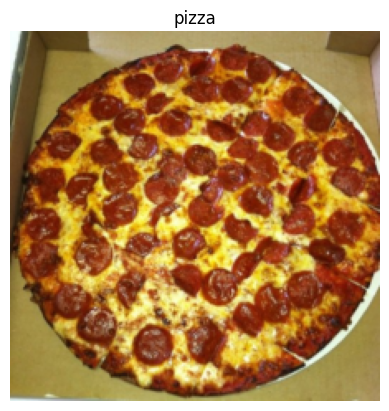

In [24]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False);

In [26]:
height = 224
width = 224
color_channel = 3
patch_size = 16

number_of_patch = int((height * width) / patch_size**2)

print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patch}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [27]:
embedding_layer_input_shape = (height, width, color_channel)
embedding_layer_output_shape = (number_of_patch, patch_size**2 * color_channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


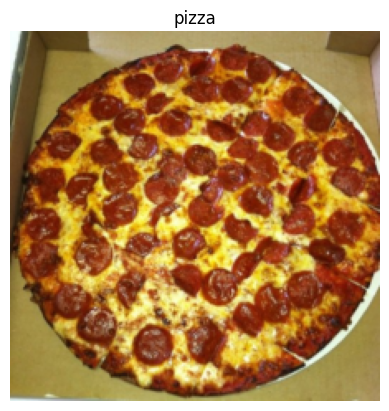

In [29]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False);

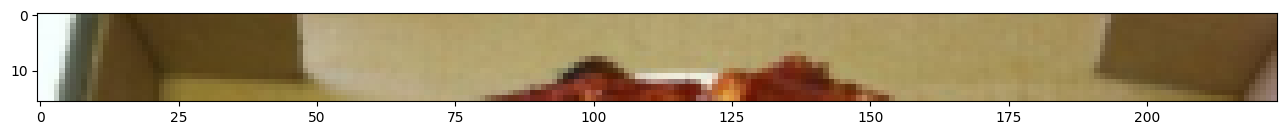

In [30]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


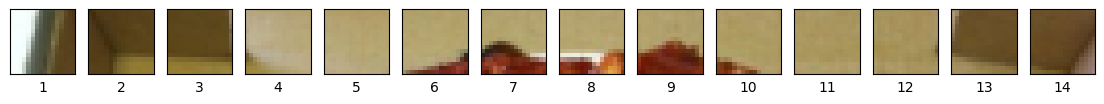

In [34]:
image_size = 224
patch_size = 16
number_patch = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {number_patch}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = 1,
                        ncols = image_size // patch_size,
                        figsize = (number_patch, number_patch),
                        sharex = True,
                        sharey = True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :]);
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


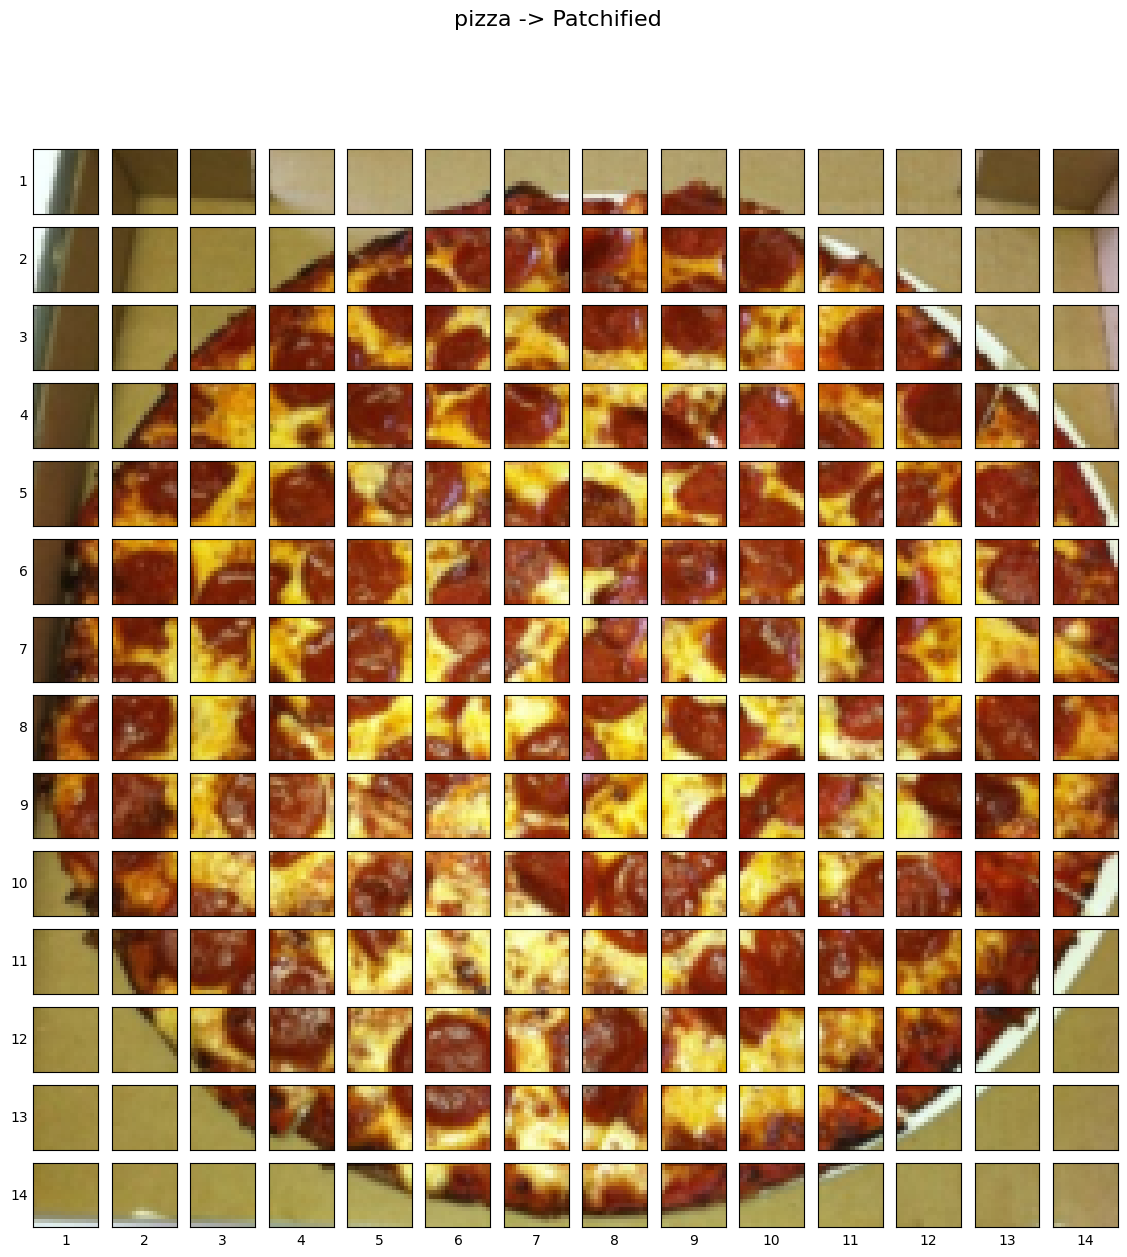

In [35]:
image_size = 224
patch_size = 16
number_patch = image_size / patch_size

assert image_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {number_patch}\
        \nNumber of patches per column: {number_patch}\
        \nTotal patches: {number_patch * number_patch}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows = image_size // patch_size,
                        ncols = image_size // patch_size,
                        figsize = (number_patch, number_patch),
                        sharex = True,
                        sharey = True)

for i, patch_height in enumerate(range(0, image_size, patch_size)):
    for j, patch_width in enumerate(range(0, image_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size,
                                        patch_width:patch_width + patch_size, :])
        axs[i, j].set_ylabel(i + 1,
                             rotation = "horizontal",
                             horizontalalignment = "right",
                             verticalalignment = "center")
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_name[label]} -> Patchified", fontsize = 16)
plt.show()

In [36]:
patch_size = 16

conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

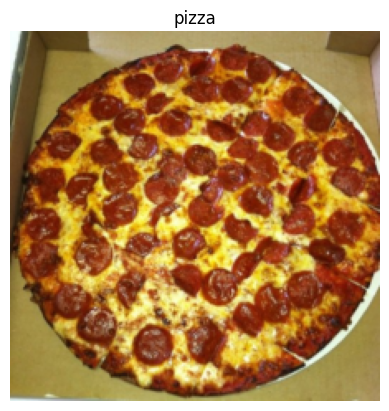

In [37]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False);

In [42]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [40]:
image_out_of_conv = conv2d(image.unsqueeze(0))

print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [44]:
random_index = random.sample(range(0, 758), k = 5)

print(f"Showing random convolutional feature maps from indexes: {random_index}")

Showing random convolutional feature maps from indexes: [317, 522, 267, 316, 659]


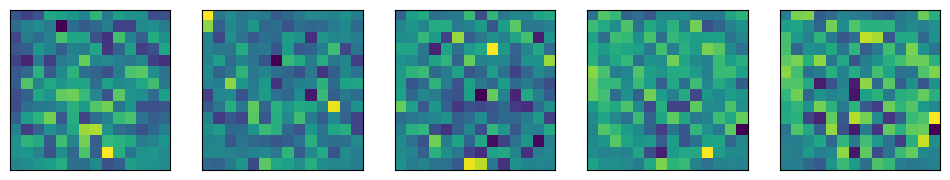

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_index):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = []);

In [46]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2283,  0.0132, -0.0483, -0.1761, -0.1983, -0.2696, -0.1926,
           -0.1239, -0.0221, -0.1277, -0.1676, -0.1478, -0.0956, -0.0659],
          [-0.1512, -0.0409, -0.1071, -0.0235, -0.1643,  0.0271,  0.0900,
           -0.0439, -0.0992, -0.0344, -0.0763, -0.2048, -0.1380, -0.2045],
          [-0.1149, -0.1234, -0.0640,  0.0022, -0.0858, -0.0491, -0.1669,
           -0.1117, -0.1632, -0.0006, -0.1153, -0.1131, -0.1946, -0.1916],
          [-0.0174, -0.2139,  0.1161,  0.0469, -0.0818, -0.2142,  0.0073,
           -0.2627, -0.1655, -0.1772,  0.1671, -0.0978, -0.2712, -0.1932],
          [-0.0623, -0.0726,  0.0176, -0.0926, -0.0319, -0.1063, -0.1214,
            0.0457, -0.2310,  0.0461, -0.2153,  0.0709,  0.0217,  0.0362],
          [ 0.0044, -0.0606, -0.0808, -0.1783,  0.0509, -0.1875,  0.0010,
           -0.0330,  0.0529, -0.0448,  0.0114,  0.0141, -0.2170, -0.0551],
          [ 0.0161,  0.0676, -0.1626, -0.1577, -0.0117, -0.1820, -0.1044,
           -0.1210, -0.0591, -0.

In [47]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [48]:
flatten = nn.Flatten(start_dim = 2, end_dim = 3)
flatten

Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


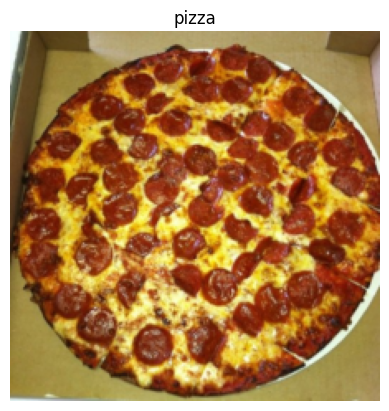

In [50]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_name[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [51]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)

print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


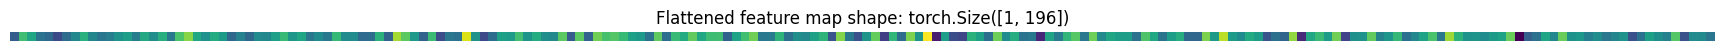

In [52]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [55]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.2283,  0.0132, -0.0483, -0.1761, -0.1983, -0.2696, -0.1926, -0.1239,
          -0.0221, -0.1277, -0.1676, -0.1478, -0.0956, -0.0659, -0.1512, -0.0409,
          -0.1071, -0.0235, -0.1643,  0.0271,  0.0900, -0.0439, -0.0992, -0.0344,
          -0.0763, -0.2048, -0.1380, -0.2045, -0.1149, -0.1234, -0.0640,  0.0022,
          -0.0858, -0.0491, -0.1669, -0.1117, -0.1632, -0.0006, -0.1153, -0.1131,
          -0.1946, -0.1916, -0.0174, -0.2139,  0.1161,  0.0469, -0.0818, -0.2142,
           0.0073, -0.2627, -0.1655, -0.1772,  0.1671, -0.0978, -0.2712, -0.1932,
          -0.0623, -0.0726,  0.0176, -0.0926, -0.0319, -0.1063, -0.1214,  0.0457,
          -0.2310,  0.0461, -0.2153,  0.0709,  0.0217,  0.0362,  0.0044, -0.0606,
          -0.0808, -0.1783,  0.0509, -0.1875,  0.0010, -0.0330,  0.0529, -0.0448,
           0.0114,  0.0141, -0.2170, -0.0551,  0.0161,  0.0676, -0.1626, -0.1577,
          -0.0117, -0.1820, -0.1044, -0.1210, -0.0591, -0.0136, -0.2459,  0.0851,
          -0.162